In [72]:
!pip install -q torch torchvision matplotlib numpy pillow

In [73]:
import os
import sys
import time
import random
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from src.config import CONFIG, MEAN, STD, NUM_CLASSES
from src.model import SegmentationModel, SegmentationLightningModule, load_pretrained_swin_transformer

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [75]:
from torchgeo.models import Swin_V2_B_Weights, swin_v2_b
import torch

dl_url = "https://huggingface.co/allenai/satlas-pretrain/resolve/main/sentinel2_swinb_si_rgb.pth?download=true"

model_path = "data/sentinel2_swinb_si_rgb.pth"

# Download model weights to ../data
torch.hub.download_url_to_file(dl_url, model_path)

100%|██████████| 444M/444M [00:09<00:00, 48.6MB/s] 


In [76]:
backbone = load_pretrained_swin_transformer(model_path=model_path, device=device)

In [77]:
# Define image transformations
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=MEAN,
        std=STD,
    ),
])

In [78]:

# Initialize the Segmentation Model
model = SegmentationModel(backbone, NUM_CLASSES)
model.to(device)

# Set the model to evaluation mode
model.eval()

SegmentationModel(
  (backbone): SwinTransformer(
    (features): Module(
      (0): Module(
        (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        (1): Permute()
        (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (1): Module(
        (0): Module(
          (attn): Module(
            (cpb_mlp): Module(
              (0): Linear(in_features=2, out_features=512, bias=True)
              (1): ReLU(inplace=True)
              (2): Linear(in_features=512, out_features=4, bias=False)
            )
            (qkv): Module()
            (proj): Module()
          )
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
          (mlp): MLP(
            (0): Linear(in_features=128, out_features=512, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=512, out_features=128, bias=True)


In [79]:
abs_checkpoint_path = os.path.abspath("best_model.ckpt")

print(os.path.exists(abs_checkpoint_path))

# Initialize the Lightning Module and load the checkpoint
lightning_model = SegmentationLightningModule.load_from_checkpoint(
    checkpoint_path=abs_checkpoint_path,
    model=model,  # Pass the initialized model
    num_classes=NUM_CLASSES,
    learning_rate=CONFIG["hyperparameters"]["learning_rate"],
    weight_decay=CONFIG["hyperparameters"]["weight_decay"],
    class_weights=torch.tensor(CONFIG["model"]["class_weights"]).to(device),
    label_smoothing=CONFIG["model"]["label_smoothing"],
)

# Set the model to evaluation mode
lightning_model.eval()
lightning_model.to(device)

True


SegmentationLightningModule(
  (model): SegmentationModel(
    (backbone): SwinTransformer(
      (features): Module(
        (0): Module(
          (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (1): Module(
          (0): Module(
            (attn): Module(
              (cpb_mlp): Module(
                (0): Linear(in_features=2, out_features=512, bias=True)
                (1): ReLU(inplace=True)
                (2): Linear(in_features=512, out_features=4, bias=False)
              )
              (qkv): Module()
              (proj): Module()
            )
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (stochastic_depth): StochasticDepth(p=0.0, mode=row)
            (mlp): MLP(
              (0): Linear(in_features=128, out_features=512, bias=True)
              (1): GELU(approximate='none')
              (2): Dropout(p=0.

In [111]:
def load_image(image_path):
    """
    Loads and preprocesses an image.
    
    Args:
        image_path (str): Path to the image.
    
    Returns:
        torch.Tensor: Preprocessed image tensor.
    """
    image = Image.open(image_path).convert("RGB")
    image = preprocess(image)
    return image.unsqueeze(0)

In [112]:
def infer(model, input_tensor):
    """
    Runs inference on a single image tensor.
    
    Args:
        model (nn.Module): The segmentation model.
        input_tensor (torch.Tensor): Preprocessed input image tensor.
    
    Returns:
        np.ndarray: Predicted mask as a NumPy array.
    """
    with torch.no_grad():
        output = model(input_tensor)
        # Assuming output is [batch_size, num_classes, H, W]
        preds = torch.argmax(output, dim=1).squeeze(0)  # [H, W]
        preds = preds.cpu().numpy()
    return preds

In [113]:
def visualize_inference(image_path, predicted_mask, mask_colors = {
    0: (0, 0, 0),           # Black
    1: (97, 74, 74),        # Brownish
    2: (38, 115, 0),        # Green
    3: (0, 197, 255),       # Cyan
    4: (207, 207, 207),     # Light Gray
}):
    """
    Displays the original image and the predicted mask.
    
    Args:
        image_path (str): Path to the original image.
        predicted_mask (np.ndarray): Predicted segmentation mask.
        mask_colors (dict, optional): Mapping from class indices to colors.
    """
    # Load the original image
    image = Image.open(image_path).convert("RGB")
    
    # Define default colors if not provided
    if mask_colors is None:
        # Generate random colors for each class
        num_classes = CONFIG["model"]["num_classes"]
        np.random.seed(42)  # For reproducibility
        mask_colors = {i: tuple(np.random.randint(0, 255, size=3)) for i in range(num_classes)}
    
    # Create a color mask
    color_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)
    for class_idx, color in mask_colors.items():
        color_mask[predicted_mask == class_idx] = color
    
    # Convert masks to PIL Images
    color_mask = Image.fromarray(color_mask)
    
    # Display images
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    
    axs[0].imshow(image)
    axs[0].set_title("Original Image")
    axs[0].axis("off")
    
    axs[1].imshow(color_mask)
    axs[1].set_title("Predicted Segmentation Mask")
    axs[1].axis("off")
    
    plt.show()

Output mask generated in: 0.51 seconds


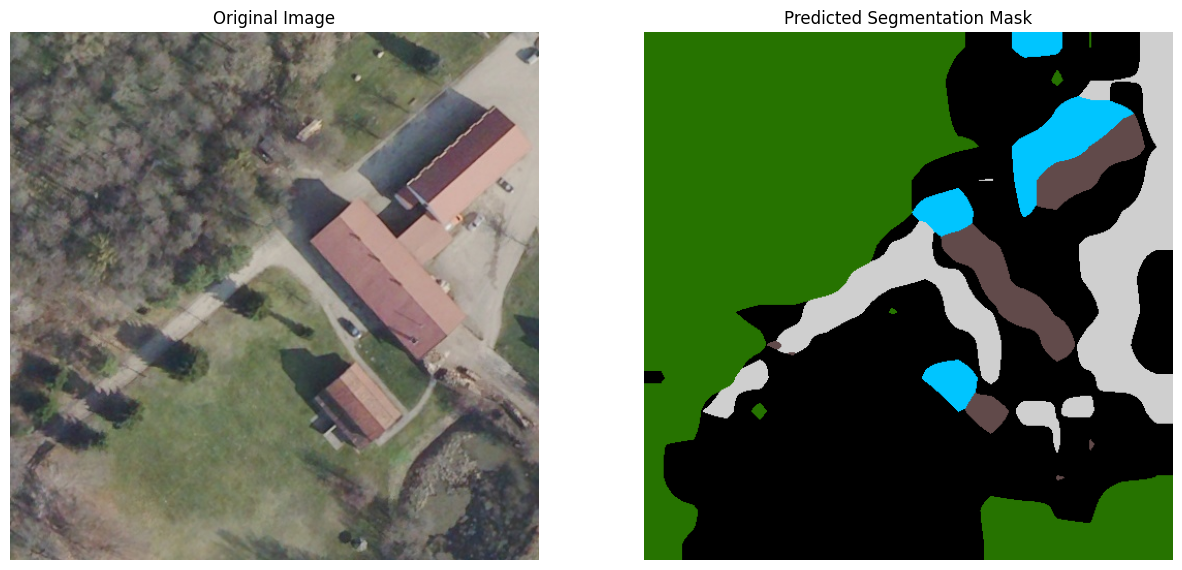

Output mask generated in: 0.51 seconds


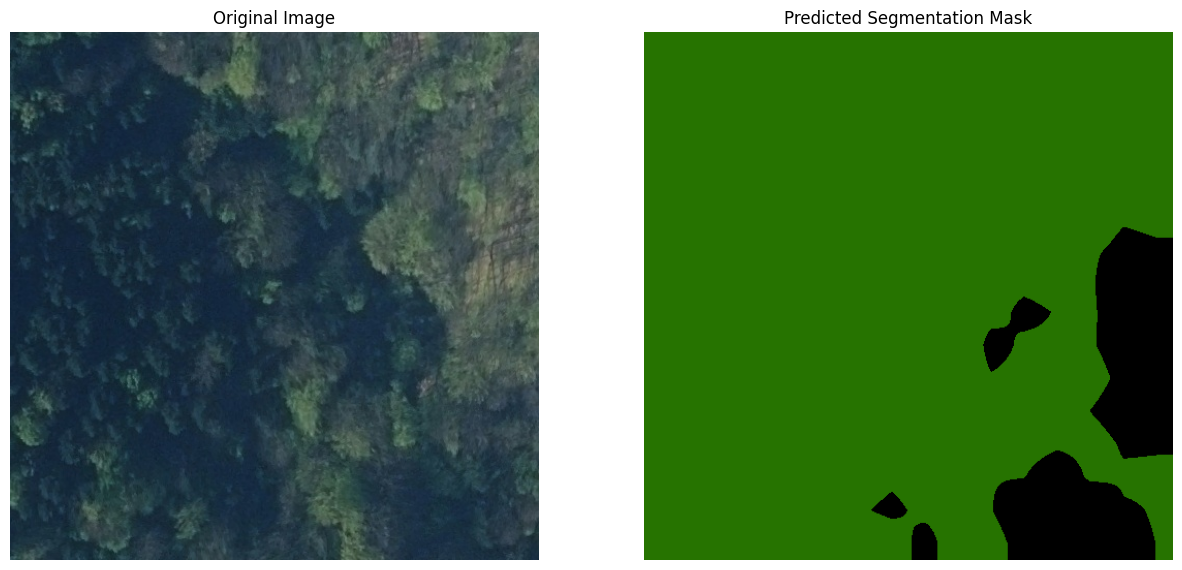

Output mask generated in: 0.47 seconds


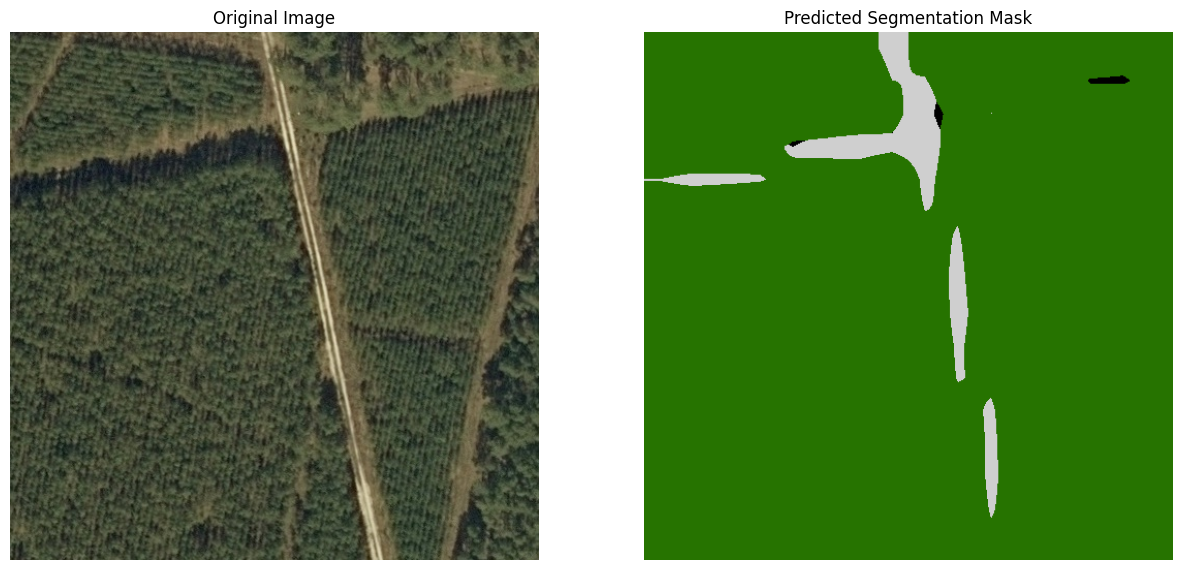

In [123]:
test_imges_names_txt_file = "data/landcoverai/test.txt"
# List of image paths for inference (random line of the file)
with open(test_imges_names_txt_file) as f:
    filenames = [line.strip() for line in f]
    filepaths = [os.path.join("data/landcoverai/output", filename) + ".jpg" for filename in filenames]


# Select 3 random images
for img_path in random.sample(filepaths, 3):
    input_tensor = load_image(img_path).to(device)
    time1 = time.time()
    pred_mask = infer(lightning_model, input_tensor)
    print(f"Output mask generated in: {(time.time() - time1):.2f} seconds")
    visualize_inference(img_path, pred_mask)